# Importing Data

In [159]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (
    GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
)
from sklearn.datasets import make_hastie_10_2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, RocCurveDisplay 
)
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')


# Data Cleaning

In [160]:
#Loading data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


#Combining train and test
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

#Duplicates and shapes
print(F"Number of duplicate rows: {len(all_data.drop('Survived', axis=1))-len(all_data.drop('Survived', axis=1).drop_duplicates())}")
print(f"Shape of train:    {train.shape}")
print(f"Shape of test:     {test.shape}")
print(f"Shape of all_data: {all_data.shape}")

Number of duplicate rows: 0
Shape of train:    (891, 12)
Shape of test:     (418, 11)
Shape of all_data: (1309, 12)


In [161]:
# Display the 5 first rows in order to have an idea of what the data looks like
all_data.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [162]:
# With the informations we have on Kaggle's website we know that: 
# SibSp is  # siblings / spouses aboard the Titanic
#Parch is # of parents / children aboard the Titanic
# We make the hypothesis that the families would stay together, hence, having an influence on their survival chances

#We regroup SibSp & Parch together
train['FamSize'] = train['SibSp'].astype(str) + train['Parch'].astype(str)
test['FamSize'] = test['SibSp'].astype(str) + test['Parch'].astype(str)
all_data['FamSize'] = all_data['SibSp'].astype(str) + all_data['Parch'].astype(str)

In [163]:
# We look for the missing data in the dataset
print(all_data.isna().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamSize           0
dtype: int64


In [164]:
# This code is filling missing values in the 'Age' column of the datasets (train and test) based on the mean age values calculated from non-missing data

# Calculate Mean Ages
df1 = all_data.dropna(subset=['Age']).groupby(['Pclass','FamSize'])['Age'].mean().reset_index()
df1.rename(columns={'Age': 'Mean_Age'}, inplace=True)

# Fill Missing Ages in Train and Test Datasets
for df in [train, test]:
    df['Age'] = df['Age'].fillna(df[['Pclass','FamSize']].merge(df1, on=['Pclass','FamSize'], how='left')['Mean_Age'])
    if df['Age'].isna().any():  # Check if there are still missing values in the 'Age' column
        df['Age'].fillna(df[['FamSize']].merge(df1, on=['FamSize'], how='left')['Mean_Age'], inplace=True)

# Update all_data and Check for Missing Values
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Check for missing values in 'all_data'
print(all_data.isna().sum())


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamSize           0
dtype: int64


In [165]:
# This code performs binning on the 'Age' column in the train and test datasets 
# and creates a new column 'Age_bin' 
# to represent the bins. Here's a breakdown of the code

# Combine Train and Test Data
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Calculate Quartiles and IQR for Binning
Q1 = all_data['Age'].quantile(0.25)
Q3 = all_data['Age'].quantile(0.75)
IQR = Q3 - Q1

# Define Bin Edges and Labels
num_bins = 10
age_bin_edges = np.linspace(start=0, stop=all_data['Age'].max(), num=num_bins + 1).astype(int)
age_bin_labels = []

# Create Bin Labels
for i in range(len(age_bin_edges) - 1):
    age_bin_labels.append("{}_to_{}".format(age_bin_edges[i], age_bin_edges[i + 1]))

# Assign Bins to 'Age_bin' Column in Train and Test Datasets
for df in [train, test]:
    df['Age_bin'] = pd.cut(df['Age'], bins=age_bin_edges, labels=age_bin_labels)

In [166]:
# This code is designed to impute missing or zero 'Fare' values 
# in the train and test datasets based on the mean fares for specific combinations 
# of 'Pclass', 'Age_bin', and 'Sex'.

# Define Impute Function
def impute_fare(row, grouped_means, overall_mean_fare):
    if row['Fare'] == 0:
        mean_fare = grouped_means[
            (grouped_means['Pclass'] == row['Pclass']) &
            (grouped_means['Age_bin'] == row['Age_bin']) &
            (grouped_means['Sex'] == row['Sex'])
        ]['Fare'].values[0]
        return mean_fare
    else:
        return row['Fare'] if pd.notnull(row['Fare']) else overall_mean_fare

# Fill missing 'Fare' values with 0 and apply impute_fare function
for df in [train, test]:
    df['Fare'].fillna(0, inplace=True)
    
    # Calculate the mean fares for each combination of 'Pclass', 'Age_bin', and 'Sex'
    grouped_means = df.groupby(['Pclass', 'Age_bin', 'Sex'])['Fare'].mean().reset_index()

    # Calculate the overall mean of the 'Fare' column from the DataFrame
    overall_mean_fare = df['Fare'][df['Fare'] != 0].mean()

    # Apply impute_fare function to impute missing fares
    df['Fare'] = df.apply(lambda row: impute_fare(row, grouped_means, overall_mean_fare), axis=1)

# Print Rows with 'Fare' Equal to 0 (Should be Empty)
test['Fare'][152]=overall_mean_fare

for df in [train, test]:
    print(df[df['Fare'] == 0])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, FamSize, Age_bin]
Index: []
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, FamSize, Age_bin]
Index: []


In [167]:
# This code is handling missing values in the 'Embarked' column of the train and test datasets
# It replaces the NaN values with the most frequent value in the 'Embarked' column

for df in [train, test]:
    most_frequent_value = df['Embarked'].value_counts().idxmax()
    df['Embarked'].replace(np.nan, most_frequent_value, inplace=True)
    print(F"Most frequent value= {most_frequent_value}")

Most frequent value= S
Most frequent value= S


In [168]:
# This code applies the Box-Cox transformation to the 'Fare' column in both the train and test datasets
# creating a new column called 'Fare_boxcox'
# Additionally, it prints the skewness of the transformed 'Fare_boxcox' column for each dataset.
for df in [train, test]:
    transformed_data, best_lambda = boxcox(df['Fare'])
    transformed_data = pd.DataFrame(transformed_data, columns=['Fare_boxcox'])
    df['Fare_boxcox'] = transformed_data['Fare_boxcox']

    print(df['Fare_boxcox'].skew())

0.21685820977079134
0.21268144264182634


In [169]:
# This code is performing binning on the 'Fare_boxcox' column in both the train and test datasets

# Combine Train and Test Data
all_data = pd.concat([train, test], ignore_index=True)

# Calculate the quantiles and IQR using 'all_data'
Q1 = all_data['Fare_boxcox'].quantile(0.25)
Q3 = all_data['Fare_boxcox'].quantile(0.75)
IQR = Q3 - Q1

# Define Lower and Upper Bounds for Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define Labels for Bins
labels = ['1', '2', '3', '4', '5']

# Apply the same binning to both 'train' and 'test' DataFrames
for df in [train, test]:
    df['Fare_bin'] = pd.cut(df['Fare_boxcox'], bins=[0, lower_bound, Q1, Q3, upper_bound, 90], labels=labels)

# Print the unique values of 'Fare_bin' to ensure they are the same in both 'train' and 'test'
print("Unique Fare_bin values in train:", train['Fare_bin'].unique())
print("Unique Fare_bin values in test:", test['Fare_bin'].unique())


Unique Fare_bin values in train: ['2', '4', '3']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']
Unique Fare_bin values in test: ['2', '3', '4']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']


In [170]:
# This code is extracting and mapping titles from the 'Name' column to a new 'Title' column in both the train and test datasets

for df in [train, test]:
    # Extract Titles from 'Name'
    df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]
    all_data['Title'] = all_data['Name'].str.split(', ').str[1].str.split('.').str[0]

    #  Map Titles to Specific Categories
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Don': 'Rare',
        'Rev': 'Rare', 'Dr': 'Rare', 'Mme': 'Mrs', 'Ms': 'Miss', 'Major': 'Rare',
        'Lady': 'Rare', 'Sir': 'Rare', 'Mlle': 'Miss', 'Col': 'Rare', 'Capt': 'Rare',
        'the Countess': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
    }

    df['Title'] = df['Title'].map(title_mapping)

In [171]:
# This code adds a new column named "Family_Size" to both the train and test datasets
# by summing Siblings and Parch
for df in [train, test]:
    df["Family_Size"] = df["SibSp"] + df["Parch"]
train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex      Age  \
0                              Braund, Mr. Owen Harris    male  22.0000   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0000   
2                               Heikkinen, Miss. Laina  female  26.0000   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0000   
4                             Allen, Mr. William Henry    male  35.0000   
..                                                 ...     ...      ...   
886                              Montvila, Rev. Juozas    male  27.0000   
887                       Graham, Miss. Margaret Edith  female  19.0000   
888           Johnston, Miss. Catherine Helen "Carrie"  female  15.0425   
889                              Behr, Mr. Karl Howell    male  26.0000   
890                                Dooley, Mr. Patrick    male  32.0000   

     SibSp  Parch            Ticket     Fare Cabin Embarked FamSize   Age_bin  \
0        1      0         A/5 21171   7.2500   NaN        S      10  16_to_24   
1        1      0          PC 17599  71.2833   C85        C      10  32_to_40   
2        0      0  STON/O2. 3101282   7.9250   NaN        S      00  24_to_32   
3        1      0            113803  53.1000  C123        S      10  32_to_40   
4        0      0            373450   8.0500   NaN        S      00  32_to_40   
..     ...    ...               ...      ...   ...      ...     ...       ...   
886      0      0            211536  13.0000   NaN        S      00  24_to_32   
887      0      0            112053  30.0000   B42        S      00  16_to_24   
888      1      2        W./C. 6607  23.4500   NaN        S      12   8_to_16   
889      0      0            111369  30.0000  C148        C      00  24_to_32   
890      0      0            370376   7.7500   NaN        Q      00  24_to_32   

     Fare_boxcox Fare_bin Title  Family_Size  
0       1.233569        2    Mr            1  
1       1.706770        4   Mrs            1  
2       1.264434        2  Miss            0  
3       1.672585        4   Mrs            1  
4       1.269713        3    Mr            0  
..           ...      ...   ...          ...  
886     1.412133        3  Rare            0  
887     1.589242        3  Miss            0  
888     1.544854        3  Miss            3  
889     1.589242        3    Mr            0  
890     1.256826        2    Mr            0  

[891 rows x 18 columns]

In [172]:
# This code is dropping a set of specified columns from both the train and test datasets

cols_to_drop=['Name', 'FamSize', 'Fare_boxcox', 'Ticket', 'Fare', 'Age', 'Cabin']
for df in [train,test]:
    df.drop(columns=cols_to_drop, inplace= True)

In [173]:
# Defining cat_variables
cat_variables=['Sex', 'Title', 'Embarked', 'Age_bin']

In [174]:
# This code performs one-hot encoding on categorical columns in the train dataset

# Initialize OneHotEncoder
train_ohe = OneHotEncoder( sparse = False)     

# Specify the categorical columns
col_names = cat_variables

# Apply the ohe encoding
dummy_cols = train_ohe.fit_transform(train[col_names])
dummy_names = [f"{prefix}_{value}" for prefix, values in zip(col_prefixes, train_ohe.categories_) for value in values]

# Create DataFrame with dummy columns
dummy_cols = pd.DataFrame(dummy_cols, columns=dummy_names, dtype=int)

# Combine the encoded columns with the non-categorical columns
ohe_train_encoded = pd.concat([train, dummy_cols], axis=1)
ohe_train_encoded = ohe_train_encoded.drop(col_names, axis=1)
ohe_train_encoded


PassengerId  Survived  Pclass  SibSp  Parch Fare_bin  Family_Size  \
0              1         0       3      1      0        2            1   
1              2         1       1      1      0        4            1   
2              3         1       3      0      0        2            0   
3              4         1       1      1      0        4            1   
4              5         0       3      0      0        3            0   
..           ...       ...     ...    ...    ...      ...          ...   
886          887         0       2      0      0        3            0   
887          888         1       1      0      0        3            0   
888          889         0       3      1      2        3            3   
889          890         1       1      0      0        3            0   
890          891         0       3      0      0        2            0   

     OHE_Sex_female  OHE_Sex_male  OHE_Title_Master  ...  OHE_Age_bin_0_to_8  \
0                 0             1                 0  ...                   0   
1                 1             0                 0  ...                   0   
2                 1             0                 0  ...                   0   
3                 1             0                 0  ...                   0   
4                 0             1                 0  ...                   0   
..              ...           ...               ...  ...                 ...   
886               0             1                 0  ...                   0   
887               1             0                 0  ...                   0   
888               1             0                 0  ...                   0   
889               0             1                 0  ...                   0   
890               0             1                 0  ...                   0   

     OHE_Age_bin_16_to_24  OHE_Age_bin_24_to_32  OHE_Age_bin_32_to_40  \
0                       1                     0                     0   
1                       0                     0                     1   
2                       0                     1                     0   
3                       0                     0                     1   
4                       0                     0                     1   
..                    ...                   ...                   ...   
886                     0                     1                     0   
887                     1                     0                     0   
888                     0                     0                     0   
889                     0                     1                     0   
890                     0                     1                     0   

     OHE_Age_bin_40_to_48  OHE_Age_bin_48_to_56  OHE_Age_bin_56_to_64  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
..                    ...                   ...                   ...   
886                     0                     0                     0   
887                     0                     0                     0   
888                     0                     0                     0   
889                     0                     0                     0   
890                     0                     0                     0   

     OHE_Age_bin_64_to_72  OHE_Age_bin_72_to_80  OHE_Age_bin_8_to_16  
0                       0                     0                    0  
1                       0                     0                    0  
2                       0                     0                    0  
3                       0                     0                    0  
4                       0                     

In [175]:
# This code performs one-hot encoding on categorical columns in the train dataset

# This code performs one-hot encoding on categorical columns in the train datase
test_ohe2 = OneHotEncoder(handle_unknown='error', sparse = False)     

# Specify the categorical columns
col_names2 = cat_variables

# Apply the ohe encoding
dummy_cols2 = test_ohe2.fit_transform(test[col_names2])
dummy_names2 = [f"{prefix}_{value}" for prefix, values in zip(col_prefixes2, test_ohe2.categories_) for value in values]

# Create DataFrame with dummy columns
dummy_cols2 = pd.DataFrame(dummy_cols2, columns=dummy_names2, dtype=int)

# Combine the encoded columns with the non-categorical columns
ohe_test_encoded2 = pd.concat([test, dummy_cols2], axis=1)
ohe_test_encoded2 = ohe_test_encoded2.drop(col_names2, axis=1)

ohe_test_encoded2

PassengerId  Pclass  SibSp  Parch Fare_bin  Family_Size  OHE_Sex_female  \
0            892       3      0      0        2            0               0   
1            893       3      1      0        2            1               1   
2            894       2      0      0        3            0               0   
3            895       3      0      0        3            0               0   
4            896       3      1      1        3            2               1   
..           ...     ...    ...    ...      ...          ...             ...   
413         1305       3      0      0        3            0               0   
414         1306       1      0      0        4            0               1   
415         1307       3      0      0        2            0               0   
416         1308       3      0      0        3            0               0   
417         1309       3      1      1        3            2               0   

     OHE_Sex_male  OHE_Title_Master  OHE_Title_Miss  ...  OHE_Age_bin_0_to_8  \
0               1                 0               0  ...                   0   
1               0                 0               0  ...                   0   
2               1                 0               0  ...                   0   
3               1                 0               0  ...                   0   
4               0                 0               0  ...                   0   
..            ...               ...             ...  ...                 ...   
413             1                 0               0  ...                   0   
414             0                 0               0  ...                   0   
415             1                 0               0  ...                   0   
416             1                 0               0  ...                   0   
417             1                 1               0  ...                   0   

     OHE_Age_bin_16_to_24  OHE_Age_bin_24_to_32  OHE_Age_bin_32_to_40  \
0                       0                     0                     1   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     1                     0   
4                       1                     0                     0   
..                    ...                   ...                   ...   
413                     0                     1                     0   
414                     0                     0                     1   
415                     0                     0                     1   
416                     0                     1                     0   
417                     1                     0                     0   

     OHE_Age_bin_40_to_48  OHE_Age_bin_48_to_56  OHE_Age_bin_56_to_64  \
0                       0                     0                     0   
1                       1                     0                     0   
2                       0                     0                     1   
3                       0                     0                     0   
4                       0                     0                     0   
..                    ...                   ...                   ...   
413                     0                     0                     0   
414                     0                     0                     0   
415                     0                     0                     0   
416                     0                     0                     0   
417                     0                     0                     0   

     OHE_Age_bin_64_to_72  OHE_Age_bin_72_to_80  OHE_Age_bin_8_to_16  
0                       0                     0                    0  
1                       0                     0                    0  
2                       0                     0                    0  
3                       0                    

In [176]:
ohe_test_encoded2.isna().sum()

PassengerId             0
Pclass                  0
SibSp                   0
Parch                   0
Fare_bin                0
Family_Size             0
OHE_Sex_female          0
OHE_Sex_male            0
OHE_Title_Master        0
OHE_Title_Miss          0
OHE_Title_Mr            0
OHE_Title_Mrs           0
OHE_Title_Rare          0
OHE_Embarked_C          0
OHE_Embarked_Q          0
OHE_Embarked_S          0
OHE_Age_bin_0_to_8      0
OHE_Age_bin_16_to_24    0
OHE_Age_bin_24_to_32    0
OHE_Age_bin_32_to_40    0
OHE_Age_bin_40_to_48    0
OHE_Age_bin_48_to_56    0
OHE_Age_bin_56_to_64    0
OHE_Age_bin_64_to_72    0
OHE_Age_bin_72_to_80    0
OHE_Age_bin_8_to_16     0
dtype: int64

In [177]:
ohe_test_encoded2.dtypes

PassengerId                int64
Pclass                     int64
SibSp                      int64
Parch                      int64
Fare_bin                category
Family_Size                int64
OHE_Sex_female             int64
OHE_Sex_male               int64
OHE_Title_Master           int64
OHE_Title_Miss             int64
OHE_Title_Mr               int64
OHE_Title_Mrs              int64
OHE_Title_Rare             int64
OHE_Embarked_C             int64
OHE_Embarked_Q             int64
OHE_Embarked_S             int64
OHE_Age_bin_0_to_8         int64
OHE_Age_bin_16_to_24       int64
OHE_Age_bin_24_to_32       int64
OHE_Age_bin_32_to_40       int64
OHE_Age_bin_40_to_48       int64
OHE_Age_bin_48_to_56       int64
OHE_Age_bin_56_to_64       int64
OHE_Age_bin_64_to_72       int64
OHE_Age_bin_72_to_80       int64
OHE_Age_bin_8_to_16        int64
dtype: object

In [178]:
# Convert 'Fare_bin' Column to Numeric
for df in [ohe_test_encoded2, ohe_train_encoded]:
    df['Fare_bin'] = pd.to_numeric(df['Fare_bin'])

ohe_train_encoded.dtypes

PassengerId             int64
Survived                int64
Pclass                  int64
SibSp                   int64
Parch                   int64
Fare_bin                int64
Family_Size             int64
OHE_Sex_female          int64
OHE_Sex_male            int64
OHE_Title_Master        int64
OHE_Title_Miss          int64
OHE_Title_Mr            int64
OHE_Title_Mrs           int64
OHE_Title_Rare          int64
OHE_Embarked_C          int64
OHE_Embarked_Q          int64
OHE_Embarked_S          int64
OHE_Age_bin_0_to_8      int64
OHE_Age_bin_16_to_24    int64
OHE_Age_bin_24_to_32    int64
OHE_Age_bin_32_to_40    int64
OHE_Age_bin_40_to_48    int64
OHE_Age_bin_48_to_56    int64
OHE_Age_bin_56_to_64    int64
OHE_Age_bin_64_to_72    int64
OHE_Age_bin_72_to_80    int64
OHE_Age_bin_8_to_16     int64
dtype: object

# ForeCast

In [179]:
# Define the plot_roc_curve Function
def plot_roc_curve(fpr, tpr, roc_auc):
    # Set Plot Title
    plt.title('Receiver Operating Characteristic')
    # Plot the ROC Curve
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # Add Legend
    plt.legend(loc = 'lower right')
    # Plot Diagonal Line
    plt.plot([0, 1], [0, 1],'r--')
    # Set Axes Limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    # Set Y-axis Label
    plt.ylabel('True Positive Rate')
    # Set X-axis Label
    plt.xlabel('False Positive Rate')
    # Display the Plot
    plt.show()

In [180]:
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    conf_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    plot_confusion_matrix(model, x_test, y_test)
    plt.show()

    #print(conf_mat)
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve 
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.title('Distribution of Probabilities for Estimated Classes')
    plt.legend(loc='best')
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

In [181]:
# This code defines a function named eval_model that evaluates the performance of a binary classification model

def eval_model(model, x_test, y_test):
    # Make Predictions and Calculate Probabilities
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)[:, 1]

    # Generate Confusion Matrix and Calculate Metrics
    conf_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # Plot confusion matrix using ConfusionMatrixDisplay
    cm_display = ConfusionMatrixDisplay(conf_mat, display_labels=model.classes_)
    cm_display.plot()
    plt.show()

    # Print Metrics
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    # Show ROC Curve 
    roc_auc = roc_auc_score(y_test, probs)
    print("AUC: ", roc_auc)

    # Plot ROC curve using plot_roc_curve
    RocCurveDisplay.from_estimator(model, x_test, y_test)
    plt.show()

    #  Create DataFrame with Results
    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs

    # Plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.title('Distribution of Probabilities for Estimated Classes')
    plt.legend(loc='best')
    plt.show()
    
    # See the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))


In [182]:
y = train['Survived']  
x = ohe_train_encoded.drop(columns=['Survived'], axis = 1)  

In [183]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x,y, train_size = 0.75, random_state = 42)

In [184]:
# This line assigns the DataFrame ohe_test_encoded2 to the variable X_pred
X_pred = ohe_test_encoded2

# AdaBoost Decision Tree

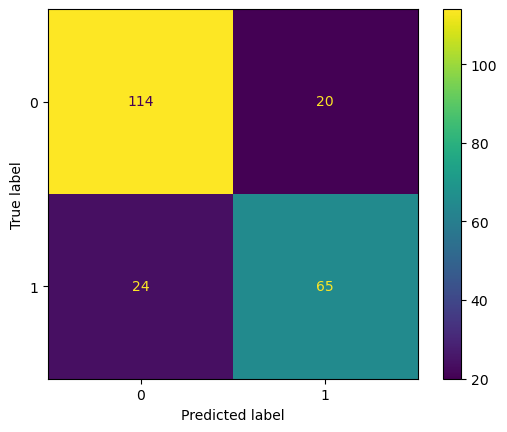



Accuracy:  0.8026905829596412
Precision:  0.7647058823529411
Recall:  0.7303370786516854
F1:  0.7471264367816092
AUC:  0.8720861982223712


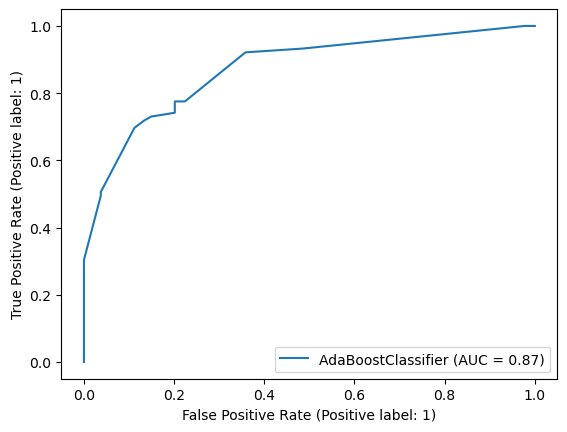

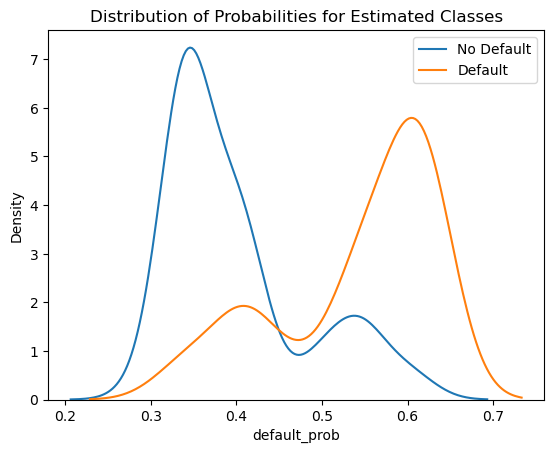

true_class  predicted_class
0           0                  0.850746
            1                  0.149254
1           1                  0.730337
            0                  0.269663
Name: proportion, dtype: float64


In [185]:
# Define a Function clf_abc
def clf_abc(X_train, y_train, n_estimators, learning_rate):
    clf_abc= AdaBoostClassifier(n_estimators=n_estimators,
                         learning_rate=learning_rate).fit(X_train, y_train)
    return clf_abc
# Train AdaBoost Classifier

abc = clf_abc(X_train, y_train, 25, 0.1)  

# Evaluate the Model
eval_model(abc, X_val, y_val)

In [63]:
# The function performs hyperparameter tuning using grid search and 
# cross-validation to find the best combination of hyperparameters for a given model

# Define the tuning Function
def tuning(model, X_train, y_train, LR):
    # Create GridSearchCV Object
    tuning= GridSearchCV(estimator = model, 
                    param_grid = LR, scoring='roc_auc')
    # Fit the Model
    tuning.fit(X_train, y_train)
    
    # Return Best Parameters and Score
    return tuning.best_params_, tuning.best_score_

In [64]:
# In this code, you are performing hyperparameter tuning for the AdaBoost classifier (abc). Let's break down the code step by step

# Define Hyperparameter Grid
LR = { 'n_estimators':[10,47,50, 49,48], 'learning_rate': [0.2, 0.25,0.19, 0.22]}

# Perform Hyperparameter Tuning
tuning(abc, X_train, y_train, LR)

({'learning_rate': 0.2, 'n_estimators': 49}, 0.8579763760926056)

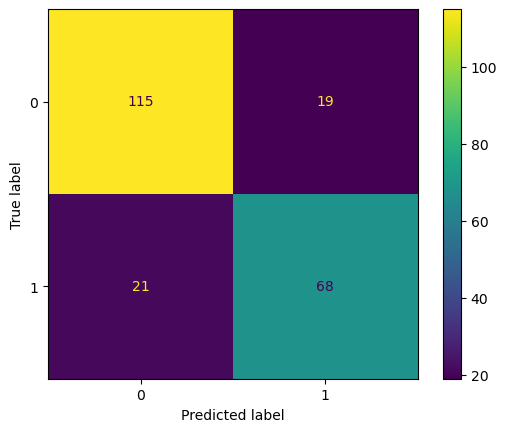



Accuracy:  0.820627802690583
Precision:  0.7816091954022989
Recall:  0.7640449438202247
F1:  0.7727272727272727
AUC:  0.8726731510984405


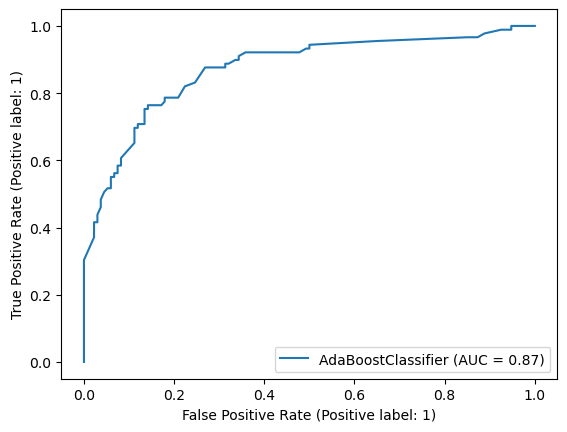

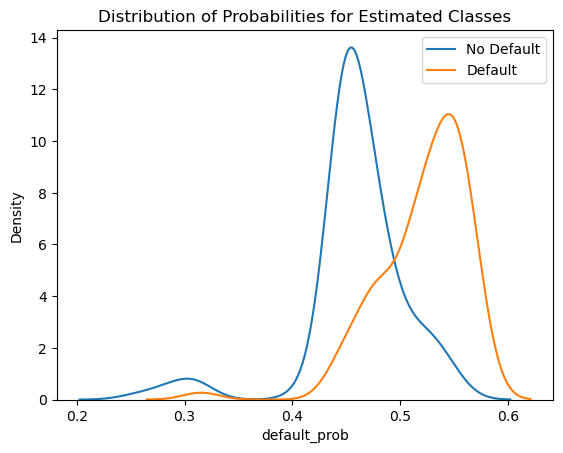

true_class  predicted_class
0           0                  0.858209
            1                  0.141791
1           1                  0.764045
            0                  0.235955
Name: proportion, dtype: float64


In [65]:
# Train AdaBoost Classifier with Specific Hyperparameters
abc2 = clf_abc(X_train, y_train, 49, 0.2)

# Evaluate the Model
eval_model(abc2, X_val, y_val)



In [66]:
# This function, df_pred, is designed for generating predictions using 
# a trained machine learning model and creating a DataFrame with the results. 

#  Define the df_pred Function
def df_pred(model, X_pred,test, ID,column_pred):
    # Make Predictions
    y_pred = model.predict(X_pred)

    # Create Predictions DataFrame
    predictions_df = pd.DataFrame({ID: test[ID],column_pred: y_pred})
    dss=str(model)
    # Save the predictions to a CSV file
    predictions_df.to_csv(dss+'final.csv',index=False)
    return print(dss+'final.csv', '\n'), print(pd.read_csv(dss+'final.csv'))

In [67]:
# This code uses the df_pred function to generate predictions using the trained AdaBoost classifier abc2 
# for the provided feature matrix (X_pred) and test dataset
df_pred(abc2, X_pred, test, 'PassengerId', 'Survived' )

AdaBoostClassifier(learning_rate=0.2, n_estimators=49)final.csv 

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


(None, None)

# AdaBoost SVC

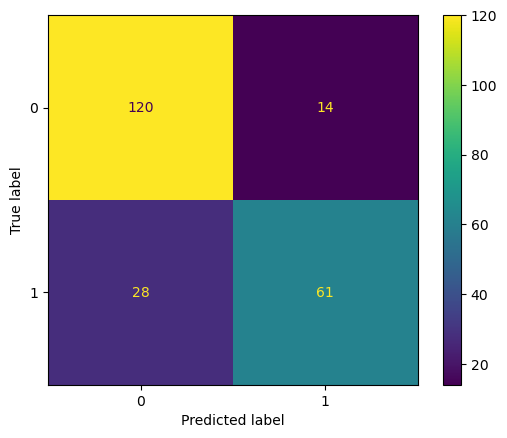



Accuracy:  0.8116591928251121
Precision:  0.8133333333333334
Recall:  0.6853932584269663
F1:  0.7439024390243902
AUC:  0.8808485661579741


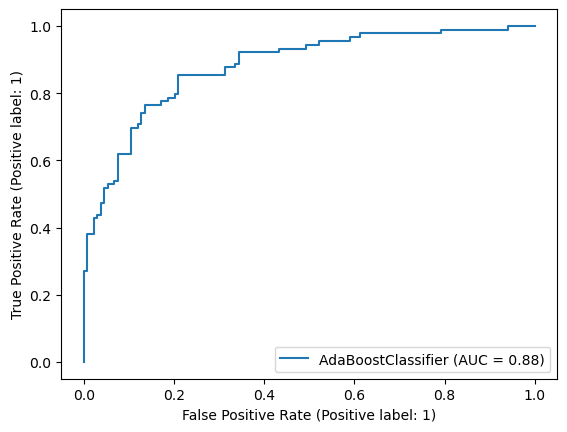

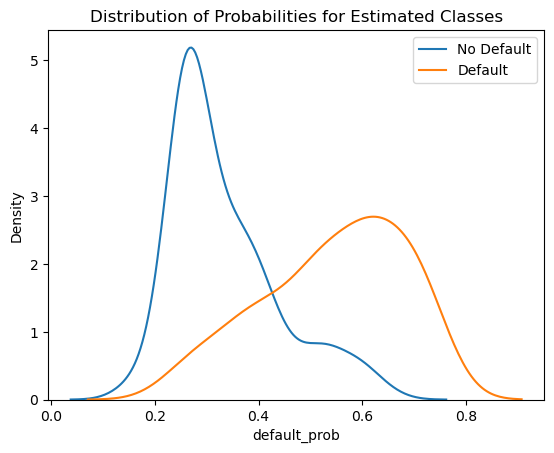

true_class  predicted_class
0           0                  0.895522
            1                  0.104478
1           1                  0.685393
            0                  0.314607
Name: proportion, dtype: float64


In [68]:
# This code defines a new function clf_abc_svc that creates an AdaBoost classifier 
# using a Support Vector Classifier (SVC) as the base estimator

# Define the clf_abc_svc Function
def clf_abc_svc(X_train, y_train, n_estimators, learning_rate):
    # Create Support Vector Classifier (SVC)
    svc=SVC(probability=True, kernel='linear')
    # Train AdaBoost Classifier with SVC
    clf_abc_svc= AdaBoostClassifier(n_estimators=n_estimators,
                         learning_rate=learning_rate, base_estimator=svc).fit(X_train, y_train)
    return clf_abc_svc

# Train AdaBoost Classifier with SVC
abc_svc = clf_abc_svc(X_train, y_train, 25, 0.1)  

# Evaluate the Model
eval_model(abc_svc, X_val, y_val)

In [70]:
# This code performs hyperparameter tuning for the AdaBoost classifier (abc_svc) 
# with a Support Vector Classifier (SVC)

# Define Hyperparameter Grid
LR = { 'n_estimators':[10,11,9], 'learning_rate': [0.14,0.13, 0.15]}
# Perform Hyperparameter Tuning
tuning(abc_svc, X_train, y_train, LR)

({'learning_rate': 0.14, 'n_estimators': 11}, 0.855578549492086)

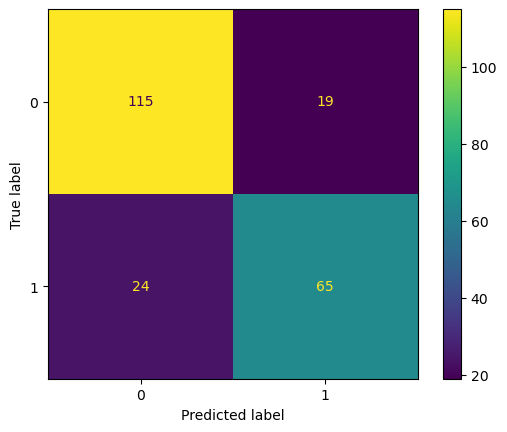



Accuracy:  0.8071748878923767
Precision:  0.7738095238095238
Recall:  0.7303370786516854
F1:  0.7514450867052023
AUC:  0.8814355190340432


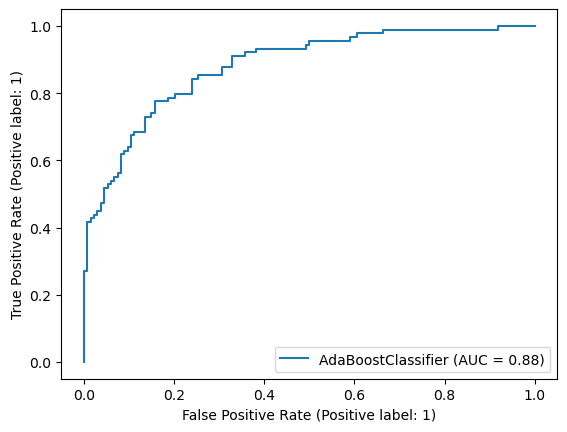

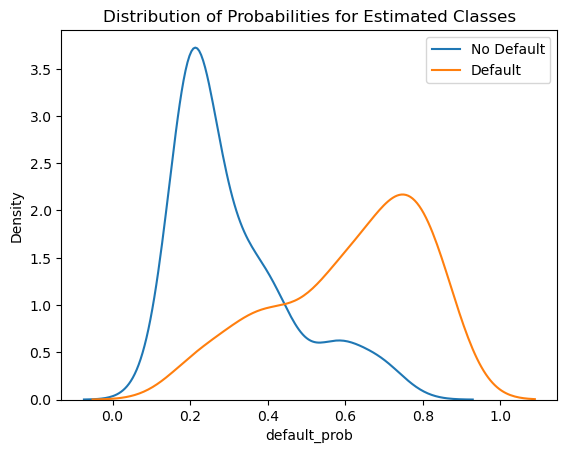

true_class  predicted_class
0           0                  0.858209
            1                  0.141791
1           1                  0.730337
            0                  0.269663
Name: proportion, dtype: float64


In [71]:
# This code trains another AdaBoost classifier (abc_svc2) with specific hyperparameters 
# and evaluates its performance on the validation set

abc_svc2 = clf_abc_svc(X_train, y_train, 11, 0.14)

# Evaluate the Model
eval_model(abc_svc2, X_val, y_val)

In [72]:
# This code uses the df_pred function to generate predictions using the trained AdaBoost classifier abc_svc2 
# for the provided feature matrix (X_pred) and test dataset.
df_pred(abc_svc2, X_pred, test, 'PassengerId', 'Survived' )

AdaBoostClassifier(base_estimator=SVC(kernel='linear', probability=True),
                   learning_rate=0.14, n_estimators=11)final.csv 

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


(None, None)

# Gradiant Boost

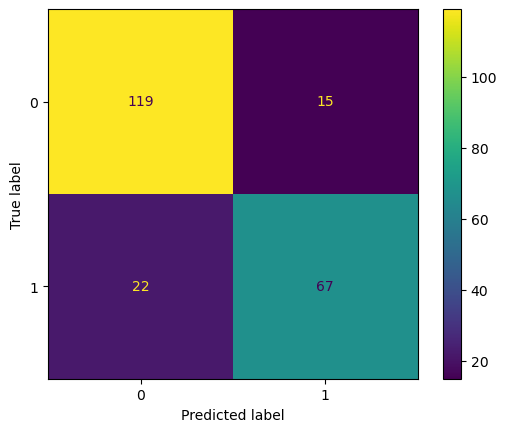



Accuracy:  0.8340807174887892
Precision:  0.8170731707317073
Recall:  0.7528089887640449
F1:  0.783625730994152
AUC:  0.8881016266979708


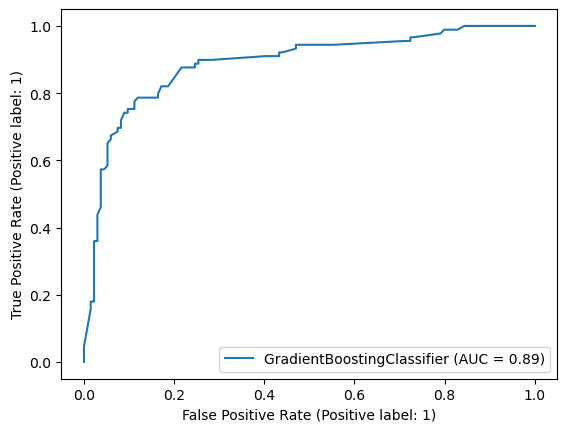

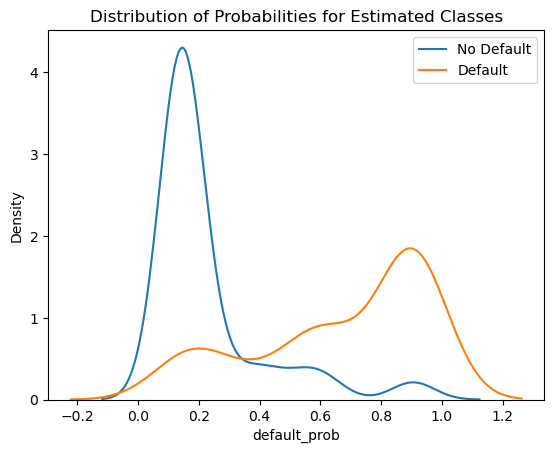

true_class  predicted_class
0           0                  0.888060
            1                  0.111940
1           1                  0.752809
            0                  0.247191
Name: proportion, dtype: float64


In [73]:
# This code defines a function clf_GBC that creates and trains a Gradient Boosting Classifier (GBC)

# Define the clf_GBC Function
def clf_GBC(X_train, y_train, n_estimators, learning_rate, max_depth) :
    clf_GBC = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,max_depth=max_depth)
    clf_GBC = clf_GBC.fit(X_train, y_train)
    return clf_GBC

# Train Gradient Boosting Classifier (clf_GBC1)
clf_GBC1 = clf_GBC(X_train, y_train, 25, 0.1, 3) 

# Evaluate the Model
eval_model(clf_GBC1, X_val, y_val)

In [74]:
# This code performs hyperparameter tuning for the Gradient Boosting Classifier

# Define Hyperparameter Grid
LR = { 'n_estimators':[22,23,24, 25], 'learning_rate': [0.09,0.15, 0.11, 0.1], 'max_depth':[1,2,3, 4]}

# Perform Hyperparameter Tuning
tuning(clf_GBC1, X_train, y_train, LR)

({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 23},
 0.8643467989605481)

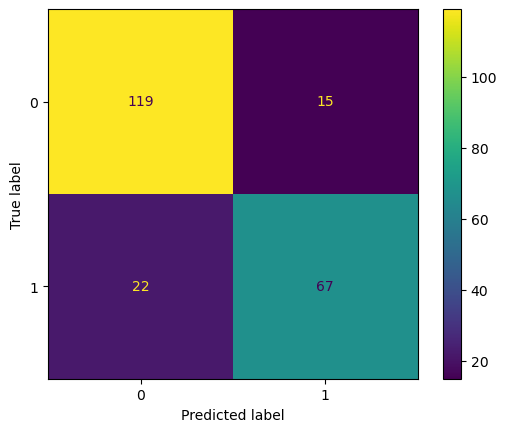



Accuracy:  0.8340807174887892
Precision:  0.8170731707317073
Recall:  0.7528089887640449
F1:  0.783625730994152
AUC:  0.8902817373805132


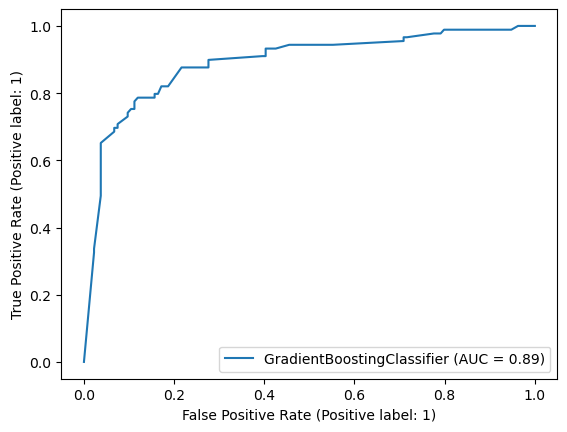

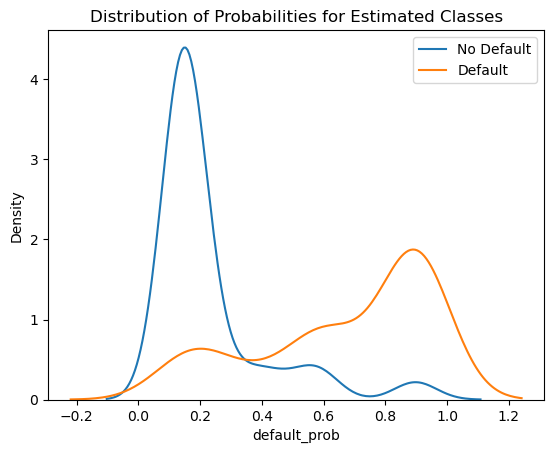

true_class  predicted_class
0           0                  0.888060
            1                  0.111940
1           1                  0.752809
            0                  0.247191
Name: proportion, dtype: float64


In [75]:
# Train Gradient Boosting Classifier 
clf_GBC2 = clf_GBC(X_train, y_train, 23, 0.1, 3) 

# Evaluate the Model
eval_model(clf_GBC2, X_val, y_val)

In [76]:
# This code uses the df_pred function to generate predictions using the trained Gradient Boosting Classifier
df_pred(clf_GBC2, X_pred, test, 'PassengerId', 'Survived' )

GradientBoostingClassifier(n_estimators=23)final.csv 

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


(None, None)

# Logistic Regression

In [77]:
# This code applies standard scaling to the feature matrices X_train, X_val, and X_pred

# Create Standard Scaler Object
sc = StandardScaler()

# Scale Training Data
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns = X_train.columns)
# Scale Validation Data
X_val_scaled = pd.DataFrame(sc.fit_transform(X_val), index=X_val.index, columns = X_val.columns)
# Scale Prediction Data
X_pred_scaled =pd.DataFrame(sc.fit_transform(X_pred), index=X_pred.index, columns = X_pred.columns)
# Display Descriptive Statistics
X_train_scaled.describe().T

count          mean       std       min       25%  \
PassengerId           668.0 -8.509494e-17  1.000749 -1.731468 -0.875334   
Pclass                668.0  0.000000e+00  1.000749 -1.620517 -0.405584   
SibSp                 668.0  3.191060e-17  1.000749 -0.467660 -0.467660   
Parch                 668.0 -6.382120e-17  1.000749 -0.468878 -0.468878   
Fare_bin              668.0 -2.579440e-16  1.000749 -1.401778 -1.401778   
Family_Size           668.0  3.722904e-17  1.000749 -0.547805 -0.547805   
OHE_Sex_female        668.0  3.722904e-17  1.000749 -0.722247 -0.722247   
OHE_Sex_male          668.0 -3.722904e-17  1.000749 -1.384569 -1.384569   
OHE_Title_Master      668.0  7.445807e-17  1.000749 -0.224309 -0.224309   
OHE_Title_Miss        668.0 -9.839102e-17  1.000749 -0.507941 -0.507941   
OHE_Title_Mr          668.0  9.307259e-17  1.000749 -1.195446 -1.195446   
OHE_Title_Mrs         668.0 -1.063687e-17  1.000749 -0.394600 -0.394600   
OHE_Title_Rare        668.0 -1.063687e-17  1.000749 -0.156652 -0.156652   
OHE_Embarked_C        668.0 -2.127373e-17  1.000749 -0.460805 -0.460805   
OHE_Embarked_Q        668.0 -1.063687e-17  1.000749 -0.308354 -0.308354   
OHE_Embarked_S        668.0 -7.445807e-17  1.000749 -1.678435 -1.678435   
OHE_Age_bin_0_to_8    668.0  3.988825e-18  1.000749 -0.268759 -0.268759   
OHE_Age_bin_16_to_24  668.0 -1.010502e-16  1.000749 -0.503273 -0.503273   
OHE_Age_bin_24_to_32  668.0 -8.110611e-17  1.000749 -0.696020 -0.696020   
OHE_Age_bin_32_to_40  668.0  5.850277e-17  1.000749 -0.409673 -0.409673   
OHE_Age_bin_40_to_48  668.0  7.312846e-17  1.000749 -0.347571 -0.347571   
OHE_Age_bin_48_to_56  668.0  6.913964e-17  1.000749 -0.238667 -0.238667   
OHE_Age_bin_56_to_64  668.0  0.000000e+00  1.000749 -0.161597 -0.161597   
OHE_Age_bin_64_to_72  668.0 -2.925139e-17  1.000749 -0.077615 -0.077615   
OHE_Age_bin_72_to_80  668.0 -1.595530e-17  1.000749 -0.054800 -0.054800   
OHE_Age_bin_8_to_16   668.0  8.775416e-17  1.000749 -0.262298 -0.262298   

                           50%       75%        max  
PassengerId           0.019583  0.876687   1.720216  
Pclass                0.809349  0.809349   0.809349  
SibSp                -0.467660  0.376656   6.286861  
Parch                -0.468878 -0.468878   7.078368  
Fare_bin              0.021304  0.021304   1.444385  
Family_Size          -0.547805  0.043364   5.363887  
OHE_Sex_female       -0.722247  1.384569   1.384569  
OHE_Sex_male          0.722247  0.722247   0.722247  
OHE_Title_Master     -0.224309 -0.224309   4.458139  
OHE_Title_Miss       -0.507941 -0.507941   1.968734  
OHE_Title_Mr          0.836508  0.836508   0.836508  
OHE_Title_Mrs        -0.394600 -0.394600   2.534210  
OHE_Title_Rare       -0.156652 -0.156652   6.383573  
OHE_Embarked_C       -0.460805 -0.460805   2.170116  
OHE_Embarked_Q       -0.308354 -0.308354   3.243030  
OHE_Embarked_S        0.595793  0.595793   0.595793  
OHE_Age_bin_0_to_8   -0.268759 -0.268759   3.720812  
OHE_Age_bin_16_to_24 -0.503273 -0.503273   1.986995  
OHE_Age_bin_24_to_32 -0.696020  1.436739   1.436739  
OHE_Age_bin_32_to_40 -0.409673 -0.409673   2.440970  
OHE_Age_bin_40_to_48 -0.347571 -0.347571   2.877113  
OHE_Age_bin_48_to_56 -0.238667 -0.238667   4.189935  
OHE_Age_bin_56_to_64 -0.161597 -0.161597   6.188224  
OHE_Age_bin_64_to_72 -0.077615 -0.077615  12.884099  
OHE_Age_bin_72_to_80 -0.054800 -0.054800  18.248288  
OHE_Age_bin_8_to_16  -0.262298 -0.262298   3.812464

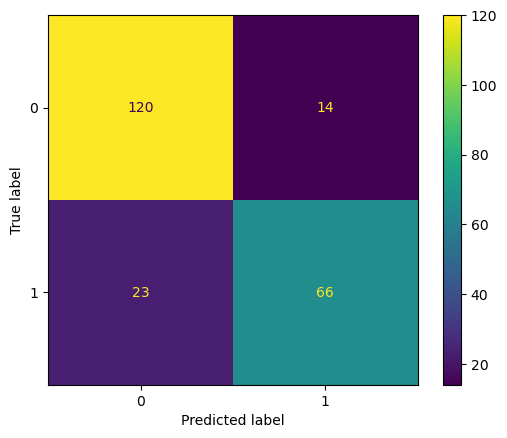



Accuracy:  0.8340807174887892
Precision:  0.825
Recall:  0.7415730337078652
F1:  0.7810650887573964
AUC:  0.886634244507798


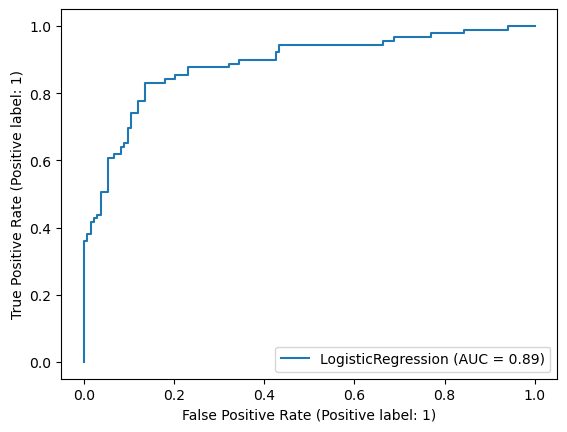

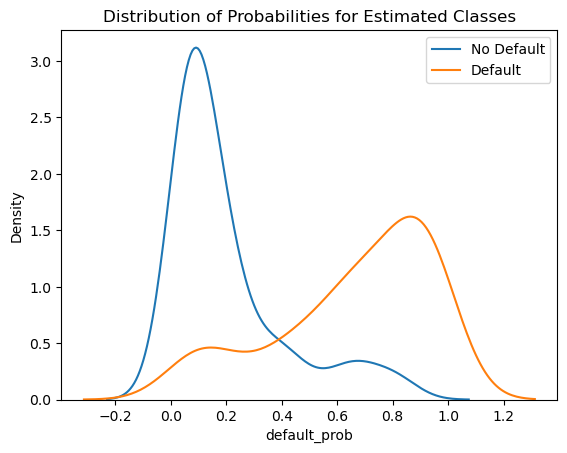

true_class  predicted_class
0           0                  0.895522
            1                  0.104478
1           1                  0.741573
            0                  0.258427
Name: proportion, dtype: float64


In [78]:
# Create Logistic Regression Model
logistic_model = LogisticRegression()
# Train Logistic Regression Model
logistic_model.fit(X_train_scaled, y_train)

# Evaluate the Model
eval_model(logistic_model, X_val_scaled, y_val)

In [79]:
# Define Hyperparameter Grid
param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
     
     'C':[0.1,0.15,0.17,0.05],
    'solver' : ['liblinear', 'saga', 'none'],
     }]

# Perform Hyperparameter Tuning
tuning(logistic_model, X_train, y_train, param_grid)

({'C': 0.17, 'penalty': 'l2', 'solver': 'liblinear'}, 0.8557391920623673)

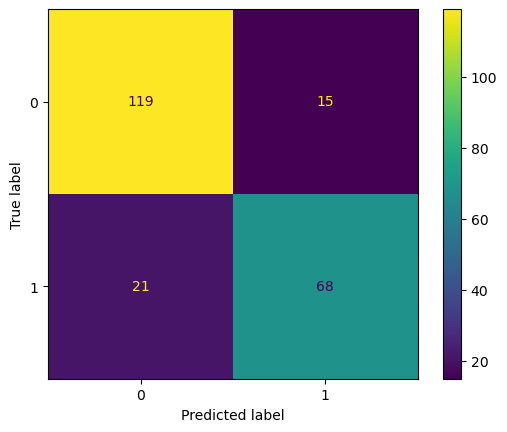



Accuracy:  0.8385650224215246
Precision:  0.8192771084337349
Recall:  0.7640449438202247
F1:  0.7906976744186045
AUC:  0.8855441891665269


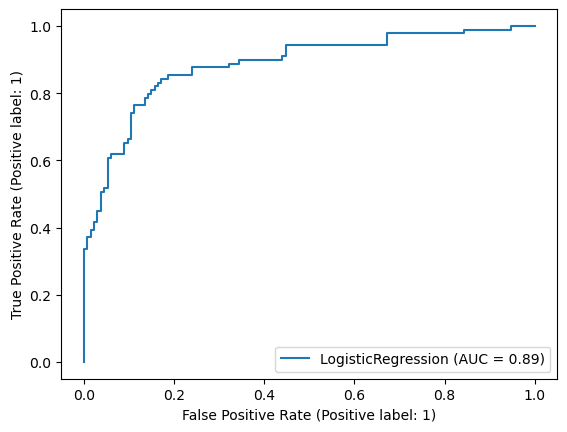

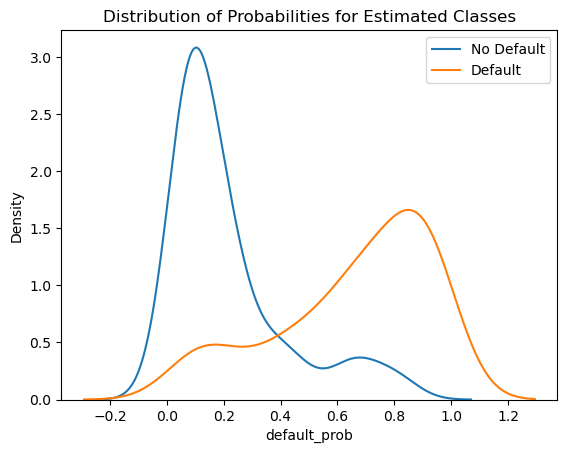

true_class  predicted_class
0           0                  0.888060
            1                  0.111940
1           1                  0.764045
            0                  0.235955
Name: proportion, dtype: float64


In [80]:
# Create Logistic Regression Model with Specific Hyperparameters
logistic_model2 = LogisticRegression( C= 0.17, penalty= 'l2', solver= 'liblinear')

# Train Logistic Regression Model
logistic_model2.fit(X_train_scaled, y_train)

# Evaluate the Model
eval_model(logistic_model2, X_val_scaled, y_val)

In [81]:
# This code uses the df_pred function to generate predictions using the trained logistic regression model logistic_model2
df_pred(logistic_model2, X_pred_scaled, test, 'PassengerId', 'Survived' )

LogisticRegression(C=0.17, solver='liblinear')final.csv 

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


(None, None)

# Random Forest

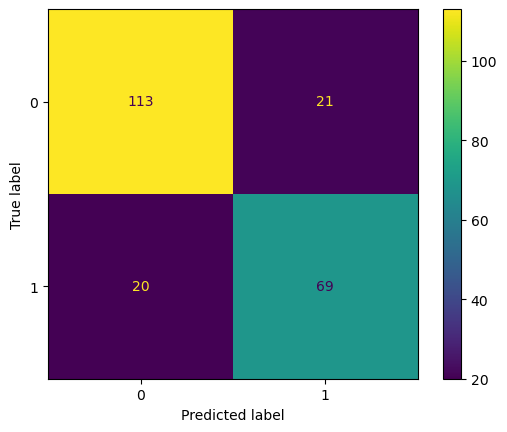



Accuracy:  0.8161434977578476
Precision:  0.7666666666666667
Recall:  0.7752808988764045
F1:  0.7709497206703911
AUC:  0.8834479288948516


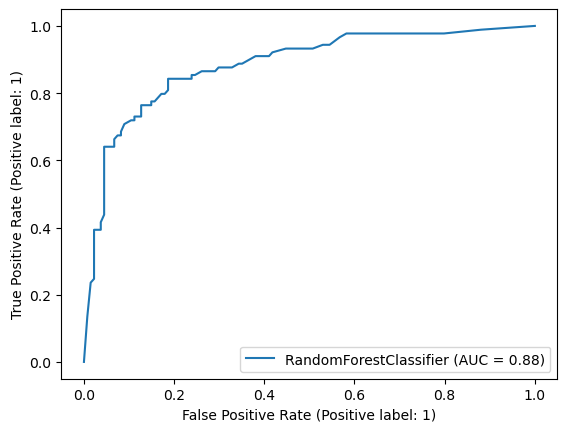

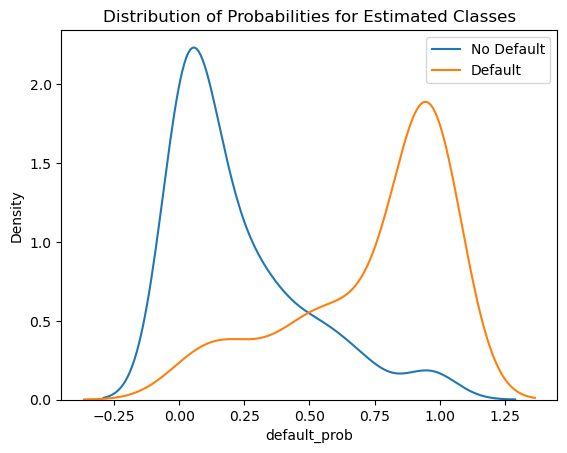

true_class  predicted_class
0           0                  0.843284
            1                  0.156716
1           1                  0.775281
            0                  0.224719
Name: proportion, dtype: float64


In [82]:
# Create Random Forest Classifier
rfc_model = RandomForestClassifier()

# Train Random Forest Classifier
rfc_model.fit(X_train, y_train)

# Evaluate the Model
eval_model(rfc_model, X_val, y_val)

In [83]:
# Define Hyperparameter Grid
LR = { 'n_estimators':[34,33,32, 35, 36,37,38], 'max_depth':[4,5,6,7,8,9,10]}

# Perform Hyperparameter Tuning
tuning(rfc_model, X_train, y_train, LR)

({'max_depth': 7, 'n_estimators': 37}, 0.8643524686983227)

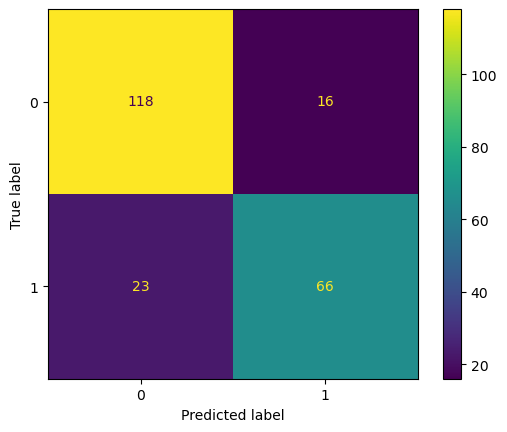



Accuracy:  0.8251121076233184
Precision:  0.8048780487804879
Recall:  0.7415730337078652
F1:  0.7719298245614036
AUC:  0.8940969310749622


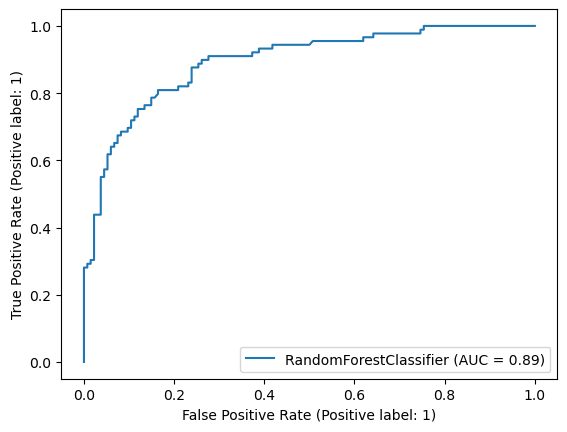

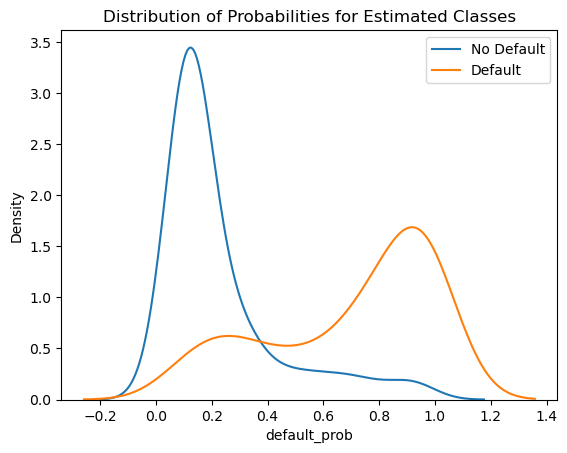

true_class  predicted_class
0           0                  0.880597
            1                  0.119403
1           1                  0.741573
            0                  0.258427
Name: proportion, dtype: float64


In [84]:
# Create Random Forest Classifier with Specific Hyperparameters
rfc_model2 = RandomForestClassifier(n_estimators = 37, max_depth = 7)

# Train Random Forest Classifier
rfc_model2.fit(X_train, y_train)

# Evaluate the Model
eval_model(rfc_model2, X_val, y_val)

In [85]:
# Generate Predictions
df_pred(rfc_model2, X_pred_scaled, test, 'PassengerId', 'Survived' )

RandomForestClassifier(max_depth=7, n_estimators=37)final.csv 

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


(None, None)

# DecisionTreeClassifier

In [138]:
# Create Decision Tree Classifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Classifier
clf_dt = clf_dt.fit(X_train, y_train)


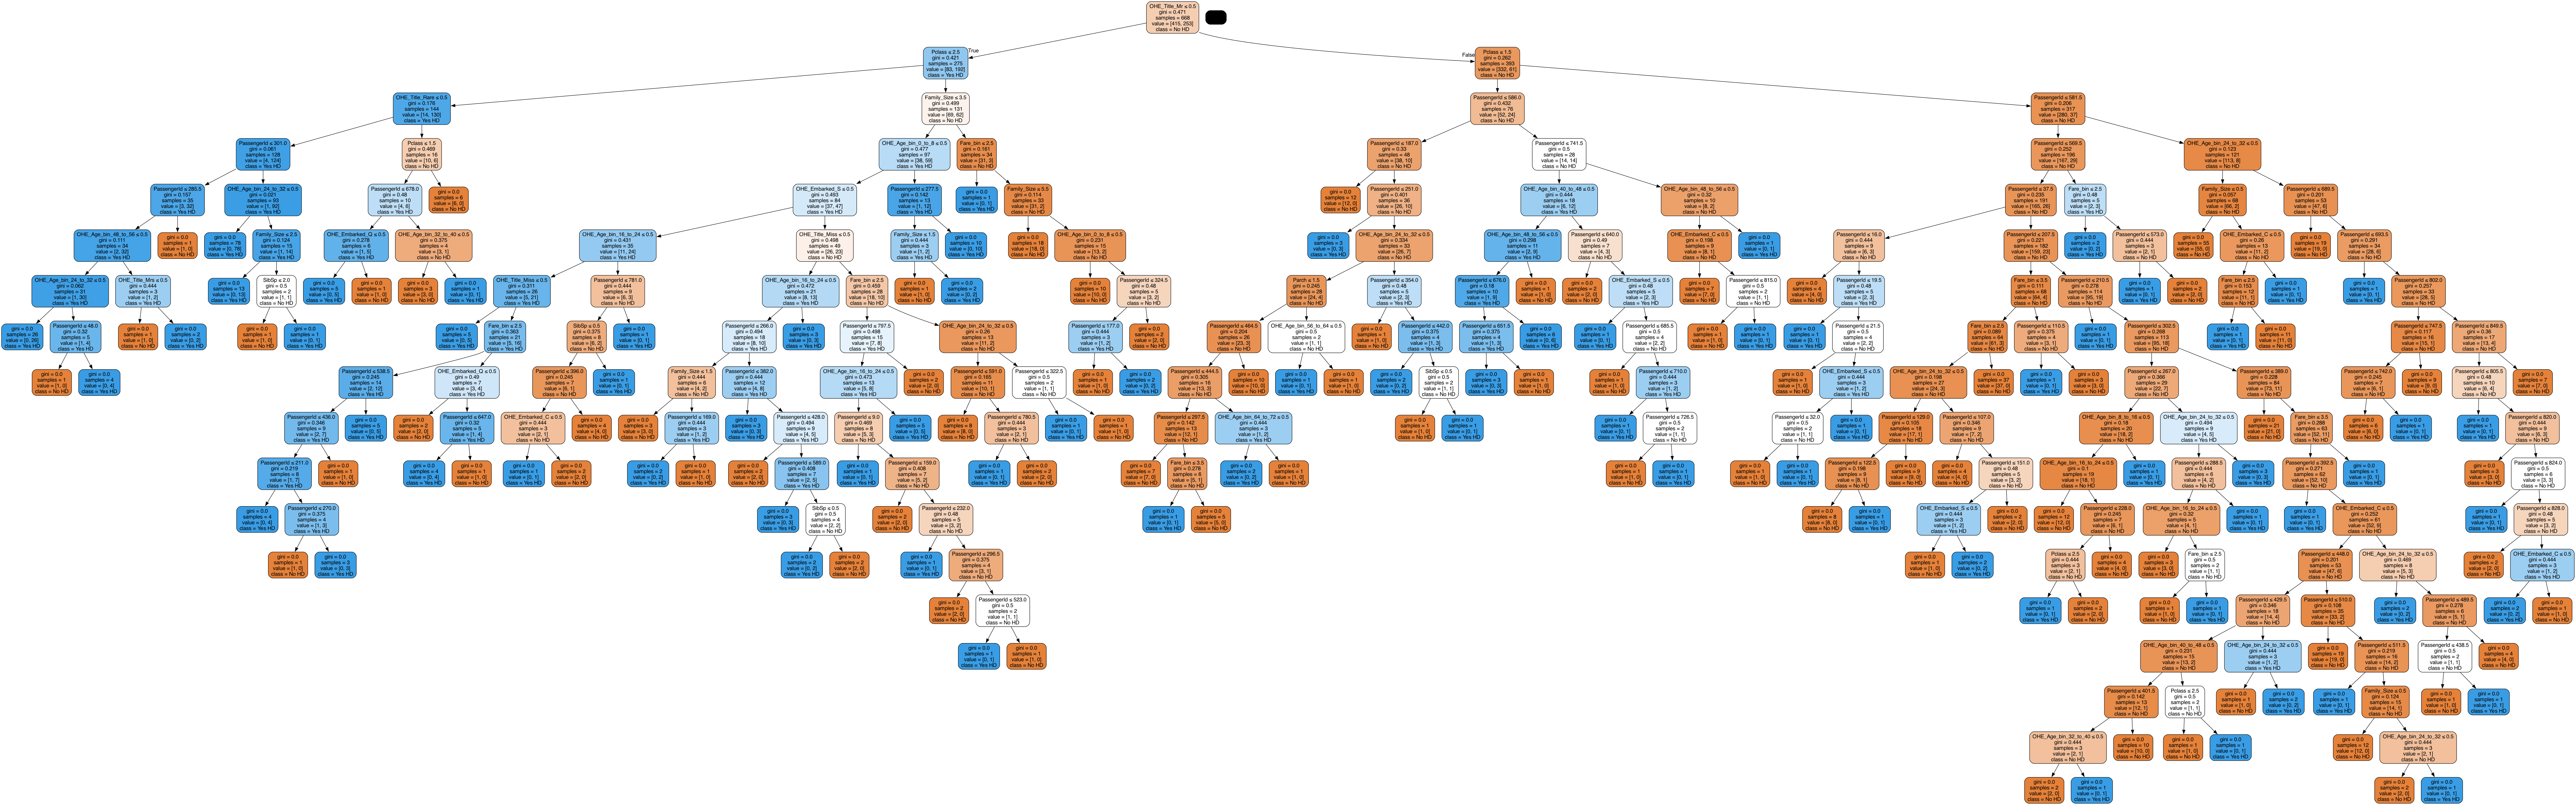

In [139]:
# Create StringIO Object
dot_data = StringIO()

# Export Decision Tree to DOT Format
export_graphviz(clf_dt, out_file=dot_data,
                feature_names=X_train.columns,
                class_names=['No HD', 'Yes HD'],
                filled=True, rounded=True, special_characters=True)

# Create a graph from the DOT data
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Display the decision tree using the Image module
Image(graph.create_png())

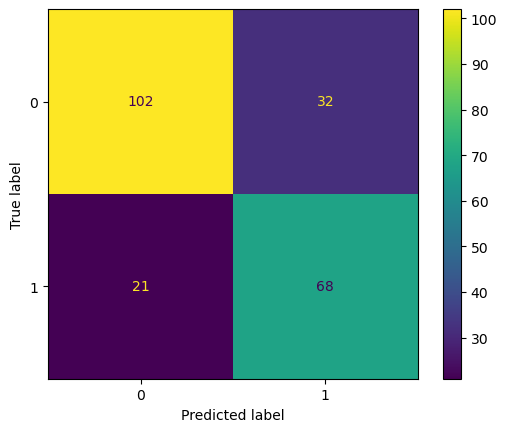



Accuracy:  0.7623318385650224
Precision:  0.68
Recall:  0.7640449438202247
F1:  0.7195767195767195
AUC:  0.7626194868354854


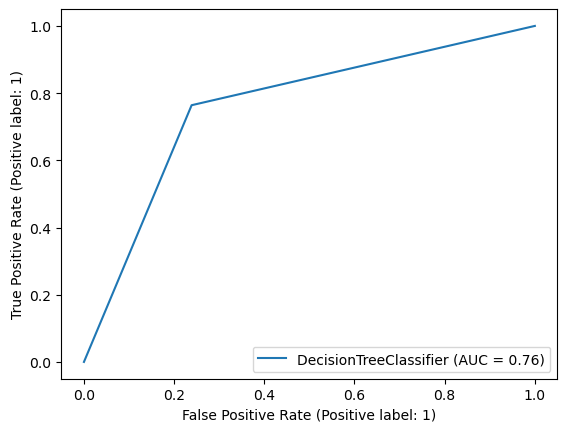

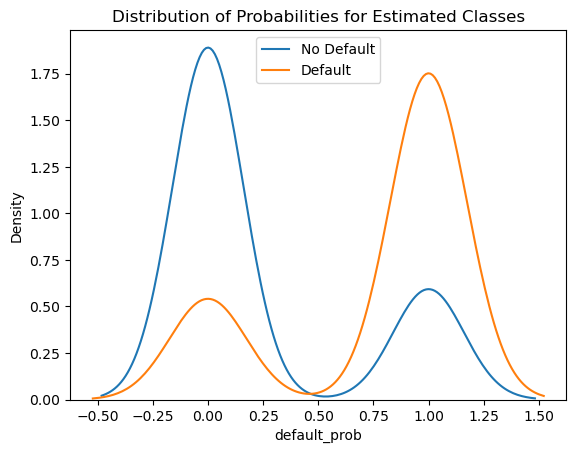

true_class  predicted_class
0           0                  0.761194
            1                  0.238806
1           1                  0.764045
            0                  0.235955
Name: proportion, dtype: float64


In [140]:
eval_model(clf_dt, X_val, y_val)

### Pruning

In [141]:
# This code performs cost-complexity pruning on a Decision Tree Classifier

# Get Cost-Complexity Pruning Path
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas =ccp_alphas[:-1]

clf_dts = []

# Iterate over Different Alpha Values
for ccp_alpha in ccp_alphas:
    # Train Pruned Decision Trees
    clf_dt=DecisionTreeClassifier(random_state=0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

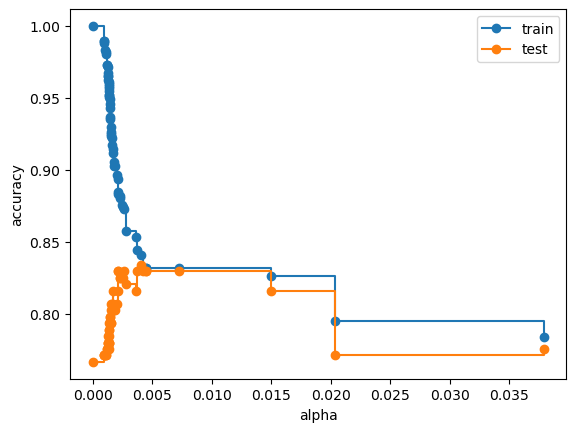

In [142]:
# This code generates a plot to visualize the accuracy of Decision Tree Classifiers 
# with different cost-complexity pruning alphas on both the training and validation datasets

# Calculate Training and Testing Scores
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_val, y_val) for clf_dt in clf_dts]

# Plot Accuracy vs. Alpha
fig, ax=plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()


<Axes: xlabel='tree'>

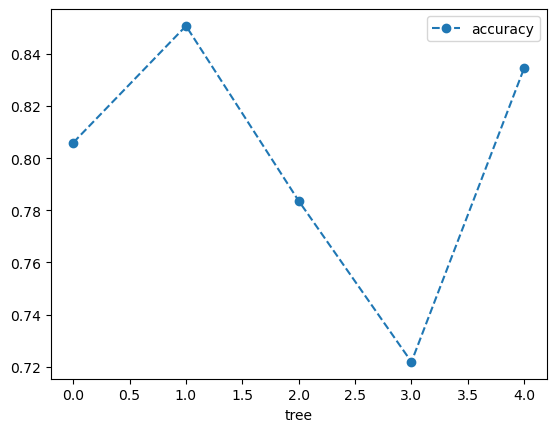

In [143]:
# Create Decision Tree Classifier with Pruning
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha = 0.0045)

# Cross-Validation
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
# Create DataFrame
df = pd.DataFrame(data= {'tree':range(5), 'accuracy':scores})

# Plot Accuracy Across Folds
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

<Axes: xlabel='alpha'>

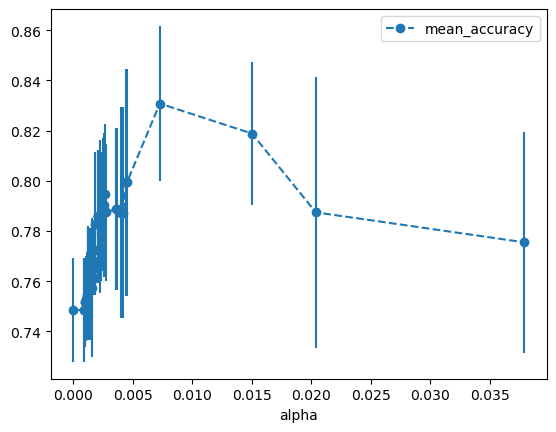

In [144]:
# his code performs cross-validation for Decision Tree Classifiers 
# with different cost-complexity pruning alphas (ccp_alpha) 
# and creates a plot to visualize the mean accuracy along with standard deviation across folds. 

# Initialize Empty List
alpha_loop_values = []

# Cross-Validation Loop
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Create DataFrame
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

# Plot Mean Accuracy with Standard Deviation
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle = '--')

In [145]:
# This code filters the alpha_results DataFrame to include rows where the alpha values are between 0.005 and 0.009

# Filter DataFrame
alpha_results[(alpha_results['alpha']>0.005)
             &
              (alpha_results['alpha']<0.009)]

alpha  mean_accuracy       std
54  0.007274       0.830816  0.030939

In [146]:
# This code identifies the ideal cost-complexity pruning alpha value by selecting a specific range from the alpha_results DataFrame

# Filter DataFrame for Ideal Alpha
ideal_ccp_alpha = alpha_results[(alpha_results['alpha']>0.005293)
             &
              (alpha_results['alpha']<0.00880)]['alpha']
#Display Ideal Alpha Values
ideal_ccp_alpha

54    0.007274
Name: alpha, dtype: float64

In [147]:
# This code converts the ideal_ccp_alpha Series, which contains a single alpha value, to a float

ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.007273550813110291

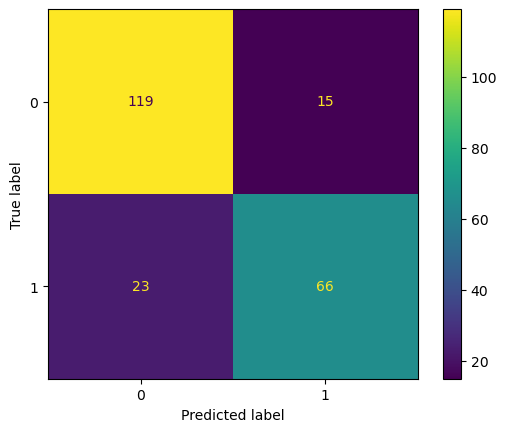



Accuracy:  0.8295964125560538
Precision:  0.8148148148148148
Recall:  0.7415730337078652
F1:  0.7764705882352941
AUC:  0.8390910615462015


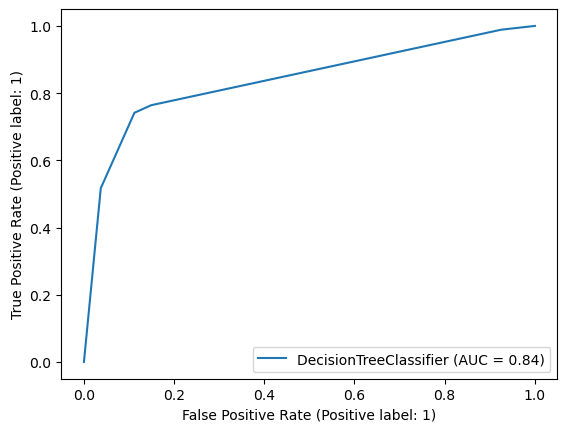

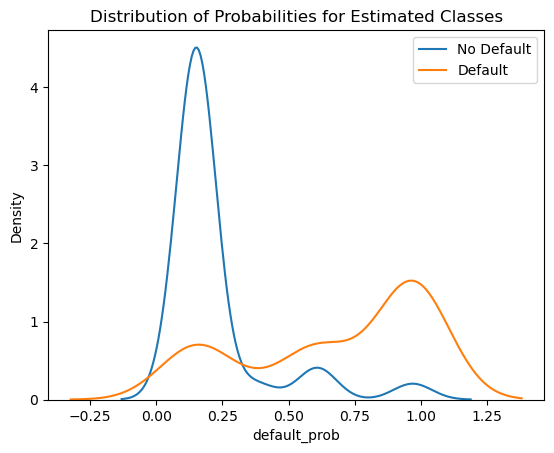

true_class  predicted_class
0           0                  0.888060
            1                  0.111940
1           1                  0.741573
            0                  0.258427
Name: proportion, dtype: float64


In [148]:
# Create Pruned Decision Tree Classifier
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = ideal_ccp_alpha)

# Fit Model
clf_dt_pruned.fit(X_train, y_train)

# Evaluate Model
eval_model(clf_dt_pruned, X_val, y_val)

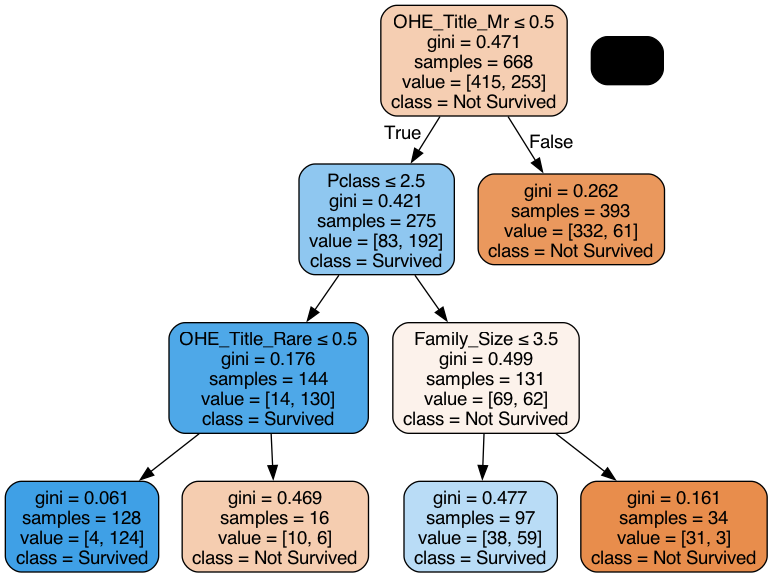

In [151]:
# This code generates a visual representation of the pruned Decision Tree Classifier 
# using Graphviz and displays it using the Image module

# Export Pruned Decision Tree to DOT Format
dot_data_pruned = StringIO()
export_graphviz(clf_dt_pruned, out_file=dot_data_pruned,
                feature_names=X_train.columns,
                class_names=['Not Survived', 'Survived'],
                filled=True, rounded=True, special_characters=True)

# Create a graph from the DOT data
graph_pruned = pydotplus.graph_from_dot_data(dot_data_pruned.getvalue())

# Display the pruned decision tree using the Image module
Image(graph_pruned.create_png())


In [152]:
df_pred(clf_dt_pruned, X_pred_scaled, test, 'PassengerId', 'Survived' )

DecisionTreeClassifier(ccp_alpha=0.007273550813110291, random_state=42)final.csv 

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         0
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


(None, None)

# XGBoost

In [153]:
# This code performs hyperparameter tuning for an XGBoost model using GridSearchCV

seed=42

# Define Hyperparameter Grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [50, 100, 150, 200],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [10,20,100],
    'min_child_weight': [1, 3, 5, 7],
    'early_stopping_rounds': [10, 15, 20]
}

# Create an XGBoost model
xgb_model = XGBClassifier()

# Use GridSearchCV to find the optimal hyperparameters
cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_strat, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)



Fitting 3 folds for each of 20736 candidates, totalling 62208 fits
Best hyperparameters: {'colsample_bytree': 0.6, 'early_stopping_rounds': 10, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 20}


In [154]:
# Create XGBoost Model
xgb_model = XGBClassifier(colsample_bytree= 0.6,
                          early_stopping_rounds=10, 
                          learning_rate= 0.01,
                          max_depth= 3,
                          min_child_weight= 1,
                          n_estimators= 50,
                          reg_alpha= 0,
                          reg_lambda=20,
                          random_state= seed,
                          objective= 'binary:logistic')

# Train the XGBoost Model
clf_xgb = xgb_model.fit(X_train, y_train, 
             verbose=True,
             eval_metric='aucpr',
             eval_set=[(X_val, y_val)])

# Display the Trained XGBoost Model
clf_xgb

[0]	validation_0-aucpr:0.82421
[1]	validation_0-aucpr:0.81640
[2]	validation_0-aucpr:0.81770
[3]	validation_0-aucpr:0.81891
[4]	validation_0-aucpr:0.81915
[5]	validation_0-aucpr:0.82009
[6]	validation_0-aucpr:0.81836
[7]	validation_0-aucpr:0.81564
[8]	validation_0-aucpr:0.81266
[9]	validation_0-aucpr:0.81229


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

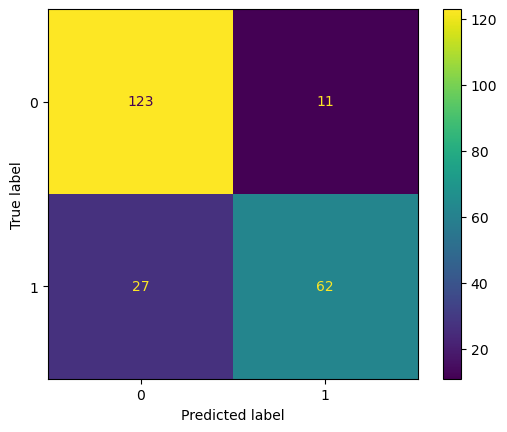



Accuracy:  0.8295964125560538
Precision:  0.8493150684931506
Recall:  0.6966292134831461
F1:  0.7654320987654321
AUC:  0.8776203253395942


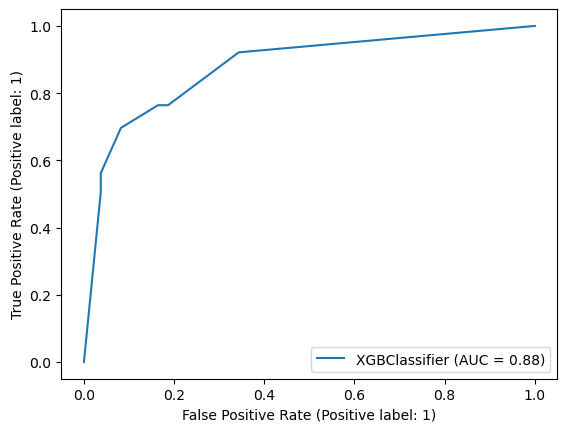

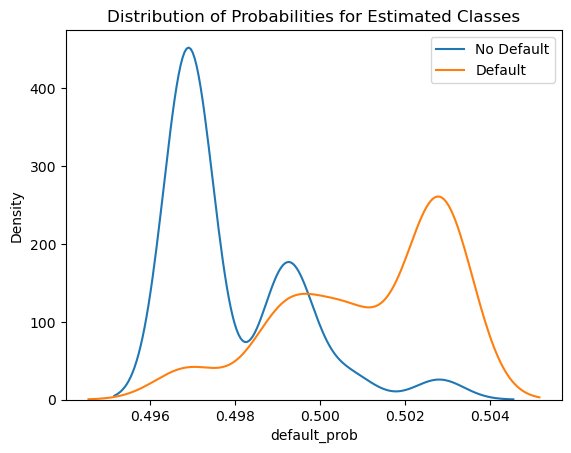

true_class  predicted_class
0           0                  0.917910
            1                  0.082090
1           1                  0.696629
            0                  0.303371
Name: proportion, dtype: float64


In [155]:
eval_model(clf_xgb, X_val, y_val)

In [156]:
def df_pred_xgb(model, X_pred,test, ID,column_pred):
    # Predict the target variable using the XGBoost model
    y_pred = model.predict(X_pred)

    # Create a DataFrame with identifier column and predicted values
    predictions_df = pd.DataFrame({ID: test[ID],column_pred: y_pred})

    # Save the predictions to a CSV file
    predictions_df.to_csv('xgb_final.csv',index=False)
    return print('xgb_final.csv', '\n'), print(pd.read_csv('xgb_final.csv'))

In [157]:
df_pred_xgb(clf_xgb, X_pred_scaled, test, 'PassengerId', 'Survived' )

xgb_final.csv 

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


(None, None)

# Model Blending

In [158]:
# This code performs blending or model averaging using the probabilities predicted by multiple trained models

#  Create a List of Trained Models
trained_models = [rfc_model2, logistic_model2, abc, abc_svc2 ]

# Generate Probabilities for Each Model
predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(X_pred)[:, 1])

# Create a Blended DataFrame
predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = X_pred['PassengerId']

# Map Blended Probabilities to Binary Predictions
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

predictions_df.to_csv('blending_base_models.csv', index=False)

In [ ]:
# Save the model
pd.read_csv('blending_base_models.csv')